In [2]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init

# use 3 prong loss and purebkg on (rnd2prong, rndbkg) 

In [181]:
bkgaeloss_3prong = np.load(f'../data_strings/bkgae_purebkg_loss_2prong.npy')
sigaeloss_3prong = np.load(f'../data_strings/sigae_3prong_loss_2prong.npy')


print(len(bkgloss_3prong),len(sigaeloss_3prong))

58822 57042


In [136]:
bkgaeloss_purebkg = np.load(f'../data_strings/bkgae_purebkg_loss_purebkg.npy')
sigaeloss_purebkg = np.load(f'../data_strings/sigae_3prong_loss_purebkg.npy')

print(len(bkgloss_purebkg), len(sigaeloss_purebkg))

930647 930647


In [137]:
correct = np.where( (sigaeloss_3prong<100) & (bkgaeloss_3prong<100))[0]

In [138]:
bkgaeloss_3prong = bkgaeloss_3prong[correct]
sigaeloss_3prong = sigaeloss_3prong[correct]
print(len(bkgloss_3prong),len(sigaeloss_3prong))

58822 58821


In [139]:
correct = np.where( (sigaeloss_purebkg<100) & (bkgaeloss_purebkg<100))[0]

In [140]:
correct.shape

(908999,)

In [141]:
bkgaeloss_purebkg = bkgaeloss_purebkg[correct]
sigaeloss_purebkg = sigaeloss_purebkg[correct]
print(len(bkgaeloss_purebkg),len(sigaeloss_purebkg))

908999 908999


(0.0, 10.0)

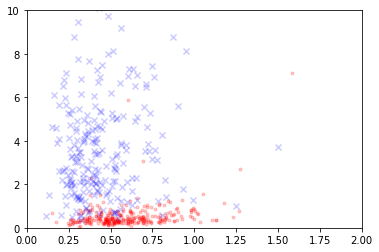

In [142]:
plt.scatter(bkgloss_3prong[:300], sigaeloss_3prong[:300], marker='.', color='red',alpha=0.2)
plt.scatter(bkgloss_purebkg[:300], sigaeloss_purebkg[:300], marker='x', color='blue',alpha=0.2)
plt.xlim(0,  2)
plt.ylim(0,  10)

In [143]:
X_bkg = np.column_stack((bkgaeloss_purebkg,sigaeloss_purebkg)) 

In [144]:
X_sig = np.column_stack((bkgaeloss_3prong,sigaeloss_3prong))

In [145]:
X = np.vstack((X_bkg,X_sig))

In [146]:
X.shape

(967820, 2)

In [147]:
y_bkg  = np.zeros(908999)
y_sig = np.ones(58821)


Y = np.concatenate((y_bkg,y_sig),axis=0)

In [148]:
Y.shape

(967820,)

In [149]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [174]:
clf = LinearDiscriminantAnalysis()

In [175]:
clf.fit(X, Y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [176]:
X_r2 = clf.transform(X)

In [177]:
X_r2.shape

(967820, 1)

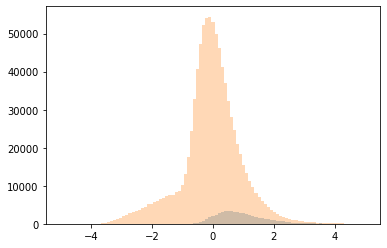

In [178]:
plt.hist(X_r2[Y==1],bins = np.linspace(-5,5,100),alpha=0.3);
plt.hist(X_r2[Y==0],bins = np.linspace(-5,5,100),alpha=0.3);

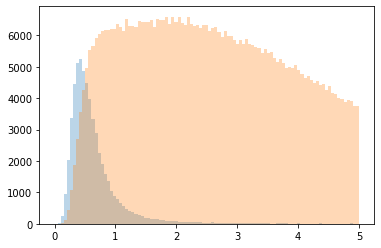

In [182]:
plt.hist(sigaeloss_3prong,bins = np.linspace(0,5,100),alpha=0.3);
plt.hist(sigaeloss_purebkg,bins = np.linspace(0,5,100),alpha=0.3);

In [2]:
f_rnd = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")
f_3prong = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5")
f_purebkg = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5")

In [3]:
f_BB1 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5")
f_BB2 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5")
f_BB3 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5")


In [4]:
dt = f_BB1.values

In [5]:
correct = (dt[:,3]>0) &(dt[:,19]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]
    
for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])
        
        
correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]

In [6]:
bb_mass = dt[:,0]

In [7]:
dt_rnd = f_rnd.values

In [8]:
rnd_idx = dt_rnd[:,-1]

In [9]:
#improve purity of trainig by only selecting properly reconstructed jets 

(array([1.2068e+04, 8.5690e+03, 4.3270e+03, 1.3555e+04, 5.8502e+04,
        2.4730e+03, 3.9300e+02, 8.6000e+01, 2.0000e+01, 7.0000e+00]),
 array([  22.78974156,  134.09720251,  245.40466346,  356.7121244 ,
         468.01958535,  579.3270463 ,  690.63450724,  801.94196819,
         913.24942914, 1024.55689008, 1135.86435103]),
 <a list of 10 Patch objects>)

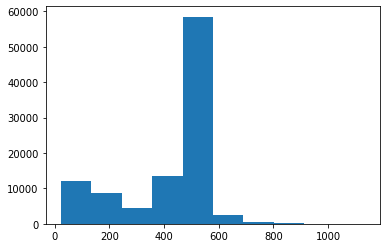

In [10]:
plt.hist(dt_rnd[rnd_idx==1,3])

# APPLY PRESELECTION BEFORE DOING THE FIT TO THE LDA

In [11]:
np.finfo(np.float32).max

3.4028235e+38

In [12]:
bkgloss_0 = np.load(f'../data_strings/bkgae_rndbkg_loss_bb1.npy')
sigaeloss_0 = np.load(f'../data_strings/sigae_2prong_loss_bb1.npy')

In [24]:
def generate_X(whichsample):
    #bkgloss_0 = np.load(f'../data_strings/bkgae_rndbkg_loss_{whichsample}.npy')
    bkgloss_1 = np.load(f'../data_strings/bkgae_purebkg_loss_{whichsample}.npy')
    sigaeloss_0 = np.load(f'../data_strings/sigae_2prong_loss_{whichsample}.npy')
    sigaeloss_1 = np.load(f'../data_strings/sigae_3prong_loss_{whichsample}.npy')
    
    sigaeloss_0[sigaeloss_0 > 2000 ] = 2000
    sigaeloss_1[sigaeloss_1 > 2000 ] = 2000
    
    #print(np.max(bkgloss_0))
    print(np.max(bkgloss_1))
    print(np.max(sigaeloss_0))
    print(np.max(sigaeloss_1))
    
    
    return np.column_stack((bkgloss_1,sigaeloss_0,sigaeloss_1))

In [25]:
X = np.vstack((generate_X('rndbkg'),generate_X('purebkg'),generate_X('2prong'),generate_X('3prong')))

322.04968
2000.0
2000.0
579.72485
2000.0
2000.0
121.7896
681.58276
688.8147
30.535763
179.0274
171.56403


In [26]:
X.shape

(1984842, 3)

In [27]:
def get_len(whichsample):
    bkgloss_0 = np.load(f'../data_strings/bkgae_{whichsample}_loss_rndbkg.npy')
    bkgloss_1 = np.load(f'../data_strings/bkgae_{whichsample}_loss_purebkg.npy')
    sigaeloss_0 = np.load(f'../data_strings/sigae_2prong_loss_2prong.npy')
    sigaeloss_1 = np.load(f'../data_strings/sigae_2prong_loss_3prong.npy')
    return len(bkgloss_0), len(bkgloss_1), len(sigaeloss_0), len(sigaeloss_1)

In [28]:
get_len('rndbkg')

(999913, 999916, 57042, 58822)

In [29]:
y_rndbkg  = np.zeros(938331)
y_purebkg = np.zeros(930647)
y_2prong  = np.ones(57042)
y_3prong  = np.ones(58822)
Y = np.concatenate((y_rndbkg,y_purebkg,y_2prong,y_3prong),axis=0)

In [30]:
Y.shape

(1984842,)

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [32]:
clf = QuadraticDiscriminantAnalysis()

In [33]:
clf.fit(X, Y)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [34]:
BB1 = generate_X('bb1')

238.16428
2000.0
2000.0


In [35]:
BB1.shape

(914617, 3)

In [36]:
BB1_prob = clf.predict_proba(BB1)

In [ ]:
https://mit.zoom.us/j/7287742919?pwd=YmdJVGpLNFQ5R0ZKS0pvWlZQRzcxdz09

In [65]:
bb1_index = np.where(BB1_prob[:,1]>0.91)[0]

In [66]:
#bb1_index = np.where((BB1[:,0]>1.5) & (BB1[:,1]>1.5) & (BB1[:,2]<3.)&(BB1[:,3]<4.))[0]

In [67]:
len(bb1_index)

228032

In [68]:
bb1_index

array([     0,      1,      2, ..., 914606, 914608, 914614])

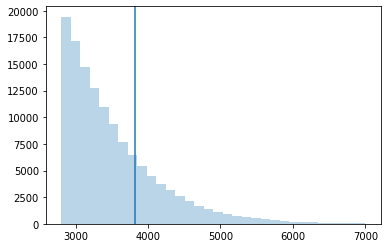

In [69]:
plt.hist(bb_mass[bb1_index],bins=np.linspace(2800,7000,33),alpha=0.3);
plt.axvline(x=3823)

In [49]:
from scipy.stats import percentileofscore

In [52]:
percentiles = [percentileofscore(BB1[:,2], i) for i in BB1[:,2]]

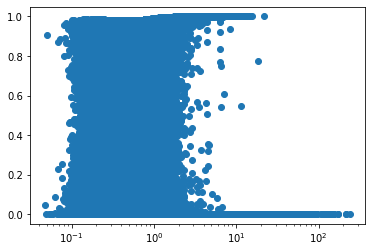

In [51]:
plt.scatter(BB1[:,0],BB1_prob[:,1])
plt.xscale('log')

In [ ]:
def get_loss(X):
    